In [37]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyLIMA.outputs import pyLIMA_plots
from cycler import cycler
sys.path.append(os.path.dirname(os.getcwd()))
from class_functions_roman_rubin import sim_events
from functions_roman_rubin import read_data

import pickle
import h5py

In [38]:
def leer_de_h5(file_name):
    with h5py.File(file_name, 'r') as archivo_h5:
        matriz = archivo_h5['covariance_matrix'][:]
        array = archivo_h5['best_model'][:]
        lista = archivo_h5.attrs['rango']
        flotante = archivo_h5.attrs['chi2']
    return matriz, array, lista, flotante


In [39]:

event_files = [f for f in os.listdir(os.path.dirname(os.getcwd())+'/test_interval_width/') if "npy" in f]
key_params = ['t0','u0','tE', 'rho', 's','q','alpha','piEN', 'piEE']

met_1_dict = {key: [] for key in key_params}
met_2_dict = {key: [] for key in key_params}
met_3_dict = {key: [] for key in key_params}
R = []
chi2 = []

param_test = []
sigma_test = []
for i in range(len(event_files)):   
    event_fit = np.load(os.path.dirname(os.getcwd())+'/test_interval_width/'+event_files[i], allow_pickle = True).item()    
    best_model = event_fit['best_model'][0:9]
    true_params = np.array([event_fit['true_params'][key] for key in ['t_center', 'u_center', 'tE', 'rho', 's','q','alpha','piEN', 'piEE']])

    chi2.append(event_fit['chi2']/42361)
    R.append(event_fit['rango'])
    sigma  = np.sqrt(np.diag(event_fit['covariance_matrix']))[0:9] 
    met_1 = abs(best_model - true_params)/abs(true_params)
    met_2 = abs(best_model - true_params)/abs(sigma) 
    met_3 = abs(sigma/best_model)
    param_test.append(best_model[2])
    sigma_test.append(sigma[2])
    for i,key in enumerate(key_params):
        met_1_dict[key].append(met_1[i])
        met_2_dict[key].append(met_2[i])
        met_3_dict[key].append(met_3[i])
    

(array([12.,  2., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.01260866,  2.6348397 ,  4.25707074,  5.87930177,  7.50153281,
         9.12376385, 10.74599488, 12.36822592, 13.99045696, 15.612688  ,
        17.23491903]),
 <BarContainer object of 10 artists>)

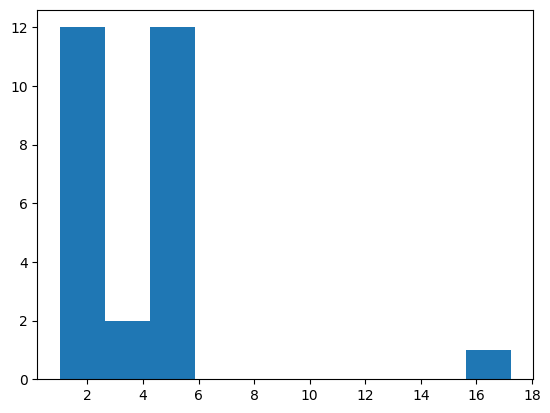

In [48]:
plt.hist(chi2)

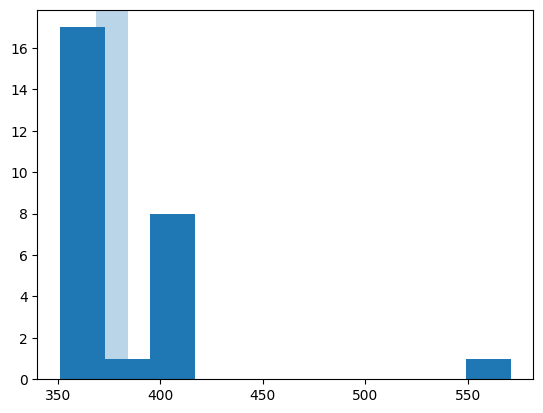

In [40]:
plt.hist(param_test)
plt.axvspan(np.mean(param_test)-max(sigma_test), np.mean(param_test)+max(sigma_test),alpha=0.3)

In [41]:

current_path = os.path.dirname(os.getcwd())
print(current_path)
path_to_save_model= current_path+'/test_sim_fit/'
info_dataset, pyLIMA_parameters, bands = read_data(path_to_save_model+'/Event_18.h5')

npts_bands = []
for b in bands:
    if b =='W149':
        npts_roman =len(bands[b])
    npts_bands.append(len(bands[b]))
npts_rr = sum(npts_bands)

nparams = len(np.load(os.path.dirname(os.getcwd())+'/test_interval_width/'+event_files[i], allow_pickle = True).item()['best_model'])
dof = npts_rr - nparams
print(dof)

/home/anibal-pc/roman_rubin
42361


In [42]:
path_save_event = os.path.dirname(os.getcwd())+'/test_interval_width/' # No pickle 

with open(path_save_event+"sim_event/Event_18.pkl", "rb") as archivo:
    evento_restaurado = pickle.load(archivo)

with open(path_save_event+"sim_event/tel_rr_18.pkl", "rb") as archivo:
    tel_rr_rest = pickle.load(archivo)



h5_files = [f for f in os.listdir(os.path.dirname(os.getcwd())+'/test_width_pickle/') if 'h5' in f]

matriz, best_model, rango, chichi = leer_de_h5(os.path.dirname(os.getcwd())+'/test_width_pickle/'+h5_files[0])
# dof = int(tel_rr_rest.total_number_of_data_points()-len(best_model))
# print(dof)
true_values = evento_restaurado.ulens_params()


chi2_results = []
met_3 = {key: [] for key in key_params}
met_2 = {key: [] for key in key_params}
met_1 = {key: [] for key in key_params}
width = []


for j in range(len(h5_files)):
    matriz, best_model, rango, chichi = leer_de_h5(os.path.dirname(os.getcwd())+'/test_width_pickle/'+h5_files[j])
    for k in range(len(key_params)):
        sigma= np.sqrt(np.diag(matriz))[0:9][k]
        met_3[key_params[k]].append(sigma/best_model[0:9][k])
        met_2[key_params[k]].append(np.abs(best_model[0:9][k] - true_values[key_params[k]]) /sigma)
        met_1[key_params[k]].append(np.abs(best_model[0:9][k] - true_values[key_params[k]]) / abs(true_values[key_params[k]]))
    width.append(rango)
    chi2_results.append(chichi/dof)

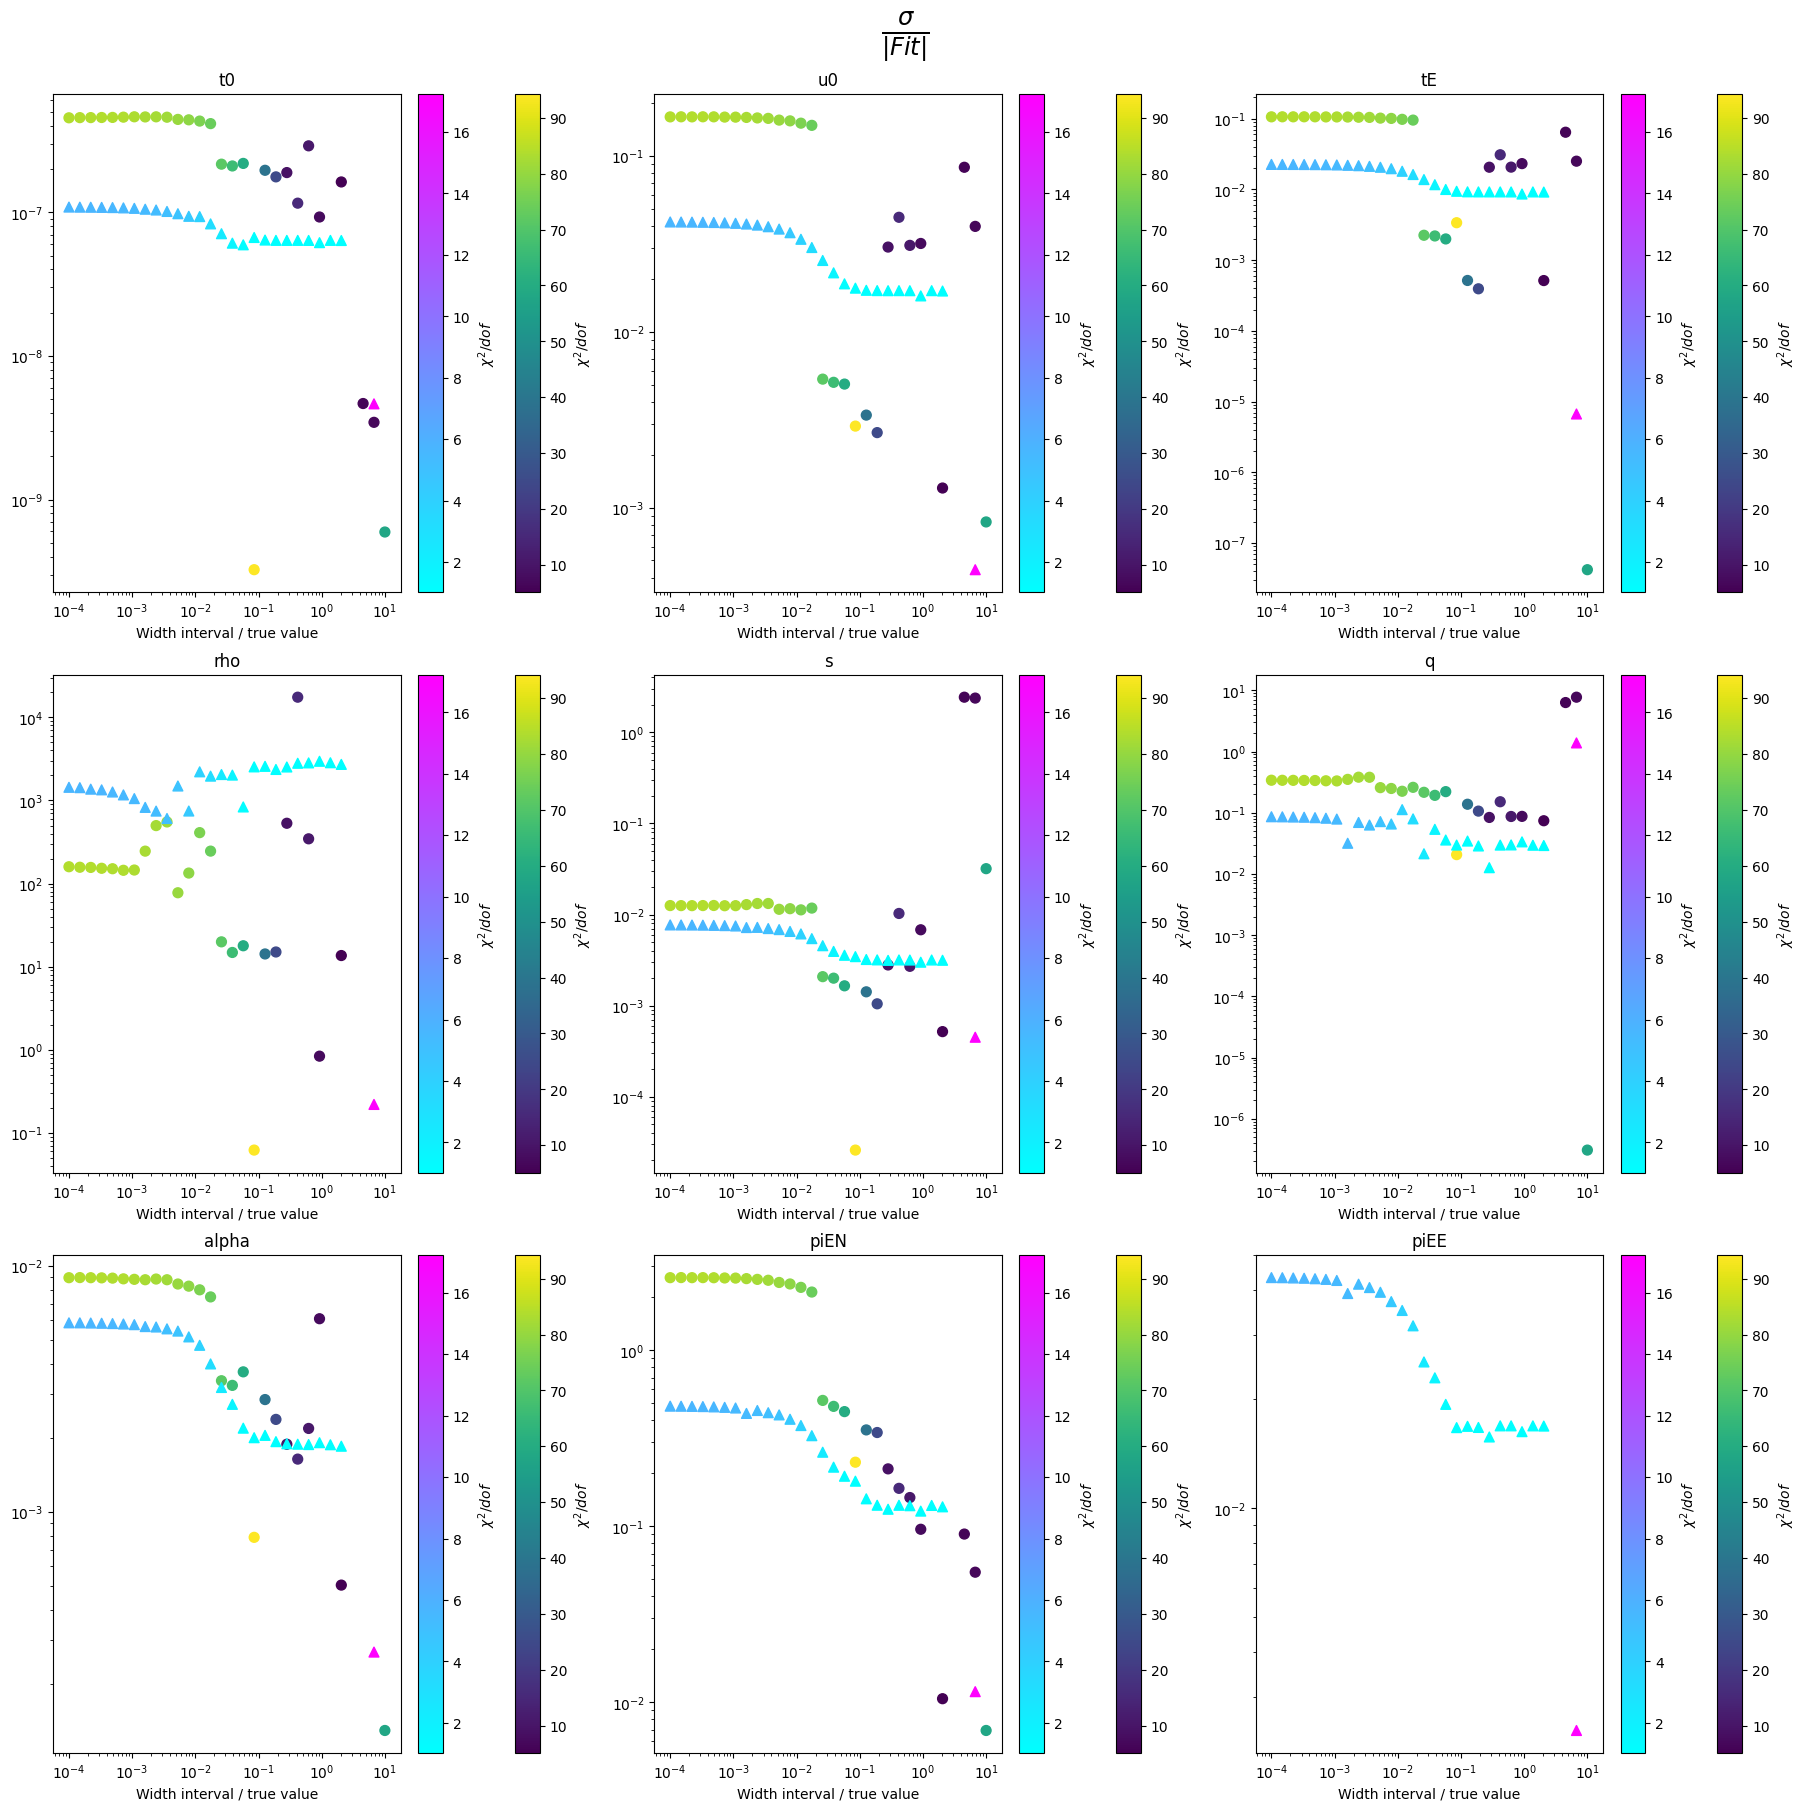

In [43]:
n_cols = 3
n_rows = -(-len(key_params) // n_cols)  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot each key in the grid
for idx, key in enumerate(key_params):
    ax = axes[idx]
    scatter1 = ax.scatter(width, met_3[key], c=chi2_results, cmap='viridis', s=50)
    scatter = ax.scatter(R, met_3_dict[key],c= chi2,cmap='cool',marker='^', s=50)
    # ax.plot(width, met_1[key], ls='', lw=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # Add labels, title, and colorbar
    ax.set_xlabel('Width interval / true value')
    # ax.set_ylabel(r'$\sigma/fit$')
    ax.set_title(key)
    cbar = plt.colorbar(scatter1, ax=ax)
    cbar.set_label(r'$\chi^2/dof$')
    cbar2 = plt.colorbar(scatter, ax=ax)
    cbar2.set_label(r'$\chi^2/dof$')

# Hide any unused subplots
for ax in axes[len(key_params):]:
    ax.set_visible(False)


# fig.text(0.5, 0.01, "Width of interval", ha='center', fontsize=25)
plt.suptitle(r"$\frac{\sigma}{|Fit|}$", fontsize=25)
# plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) 
plt.show()


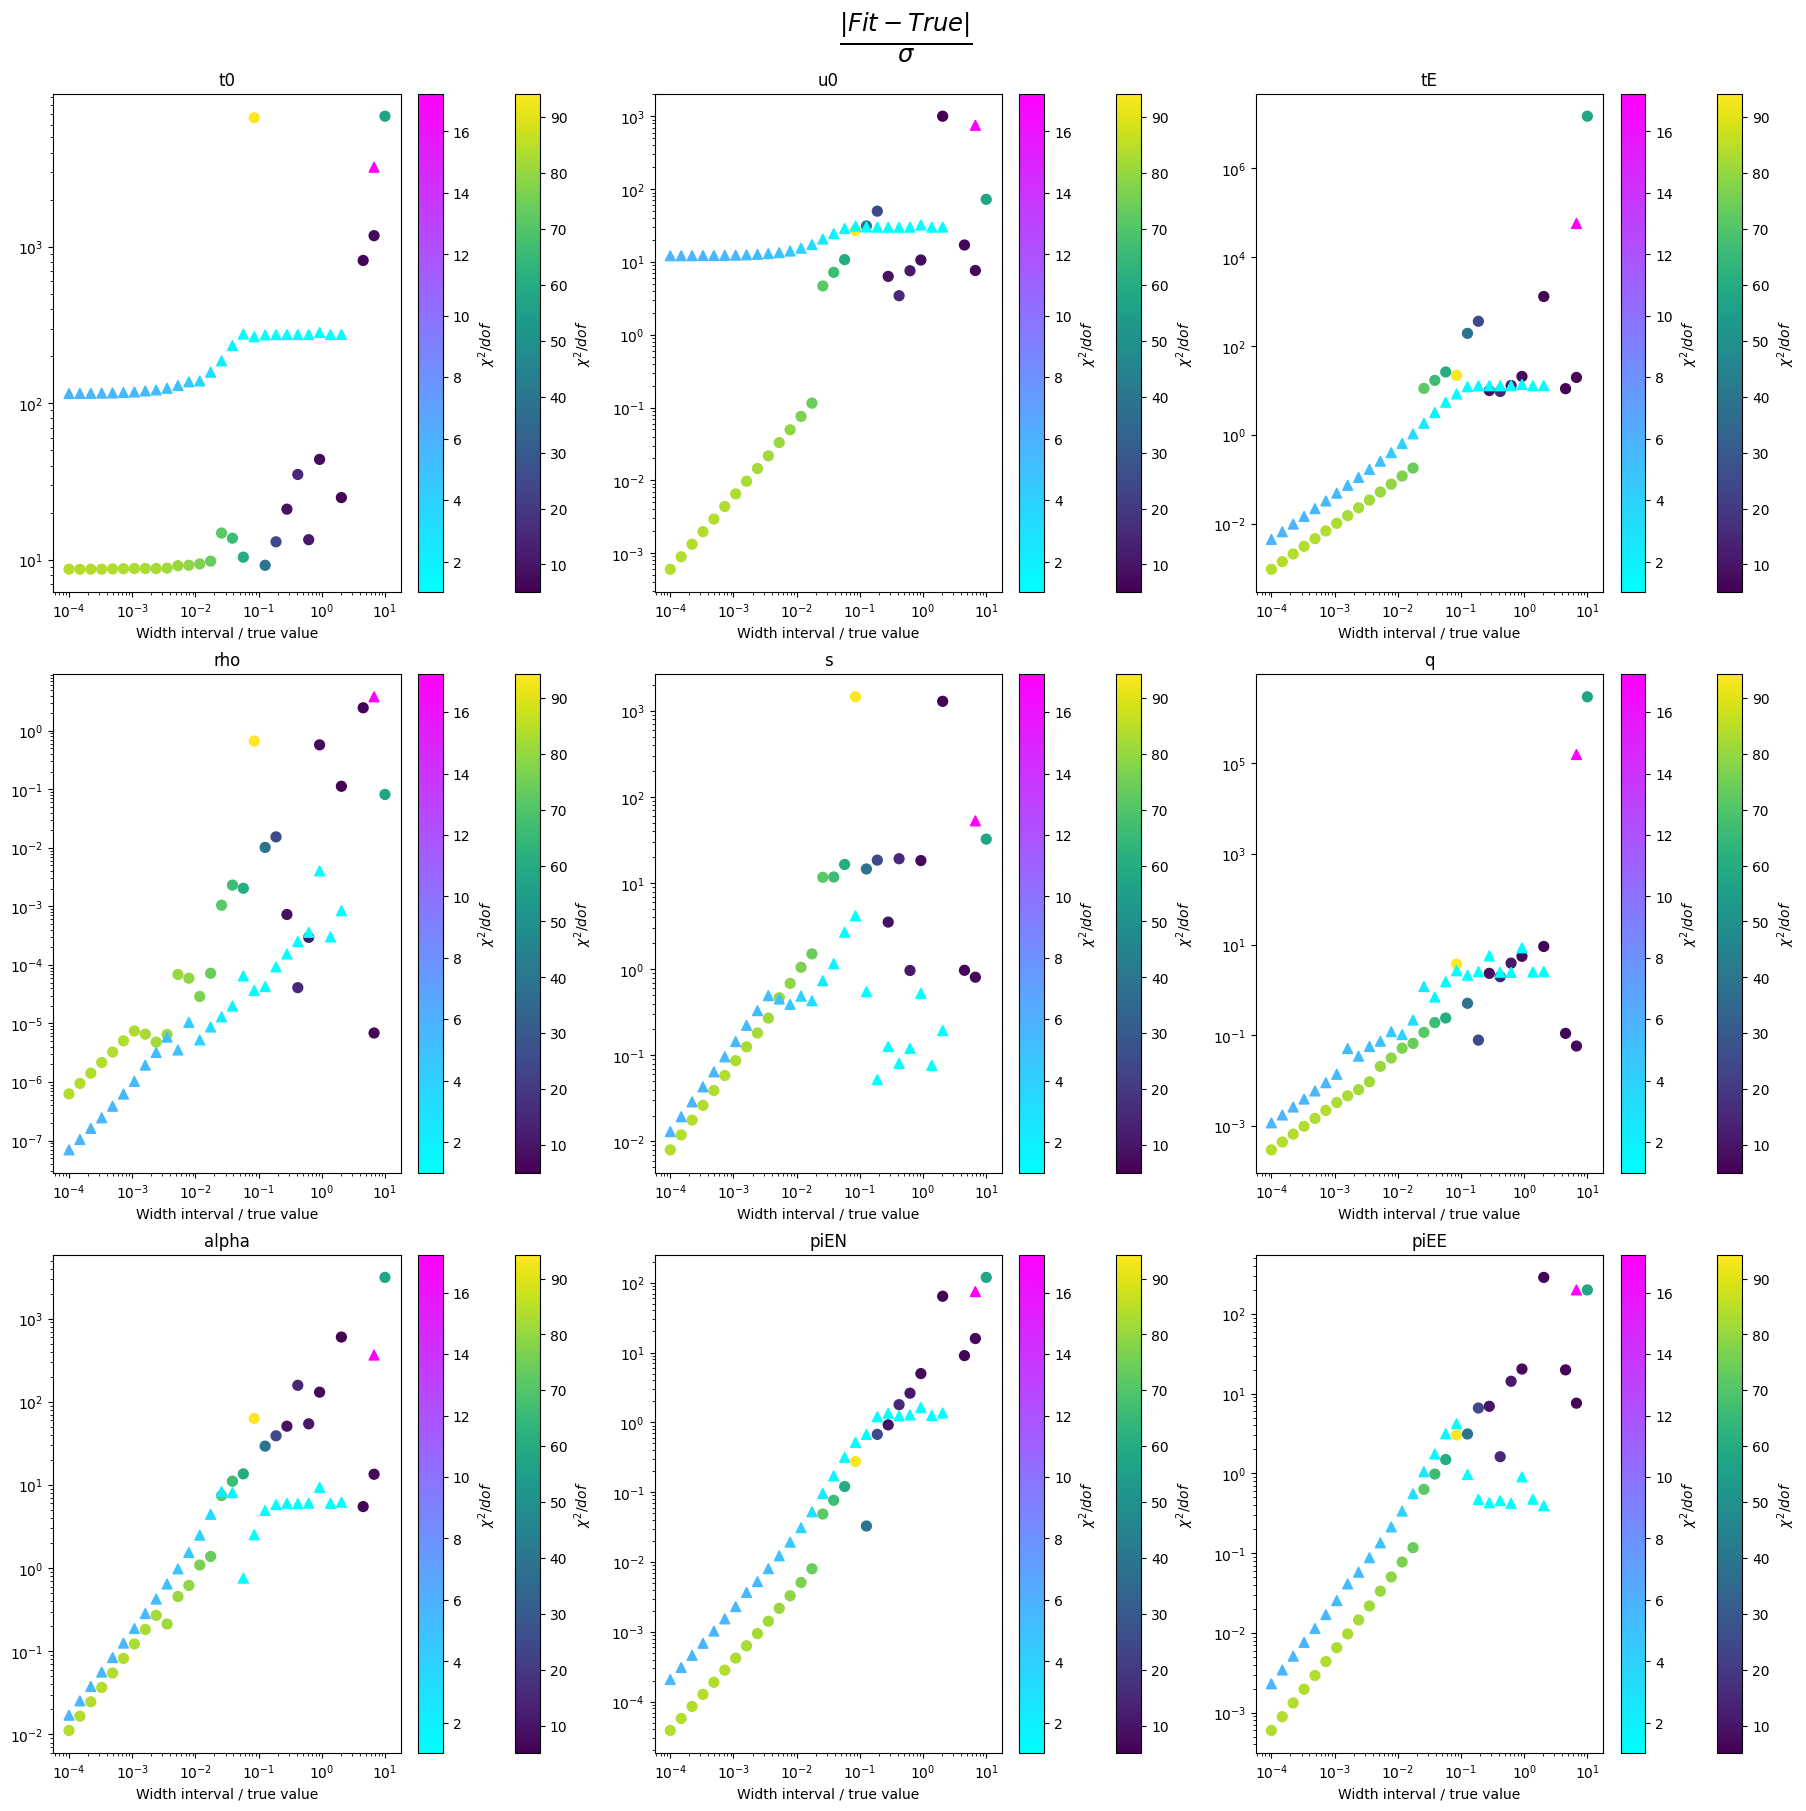

In [44]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot each key in the grid
for idx, key in enumerate(key_params):
    ax = axes[idx]
    scatter1 = ax.scatter(width, met_2[key], c=chi2_results, cmap='viridis', s=50)
    scatter = ax.scatter(R, met_2_dict[key],c= chi2,cmap='cool',marker='^', s=50)
    # ax.plot(width, met_1[key], ls='', lw=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # Add labels, title, and colorbar
    ax.set_xlabel('Width interval / true value')
    # ax.set_ylabel(r'$\sigma/fit$')
    ax.set_title(key)
    cbar = plt.colorbar(scatter1, ax=ax)
    cbar.set_label(r'$\chi^2/dof$')
    cbar2 = plt.colorbar(scatter, ax=ax)
    cbar2.set_label(r'$\chi^2/dof$')

# Hide any unused subplots
for ax in axes[len(key_params):]:
    ax.set_visible(False)

# fig.text(0.5, 0.01, "Width of interval", ha='center', fontsize=25)
plt.suptitle(r"$\frac{|Fit-True|}{\sigma}$", fontsize=25)
# plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) 
plt.show()


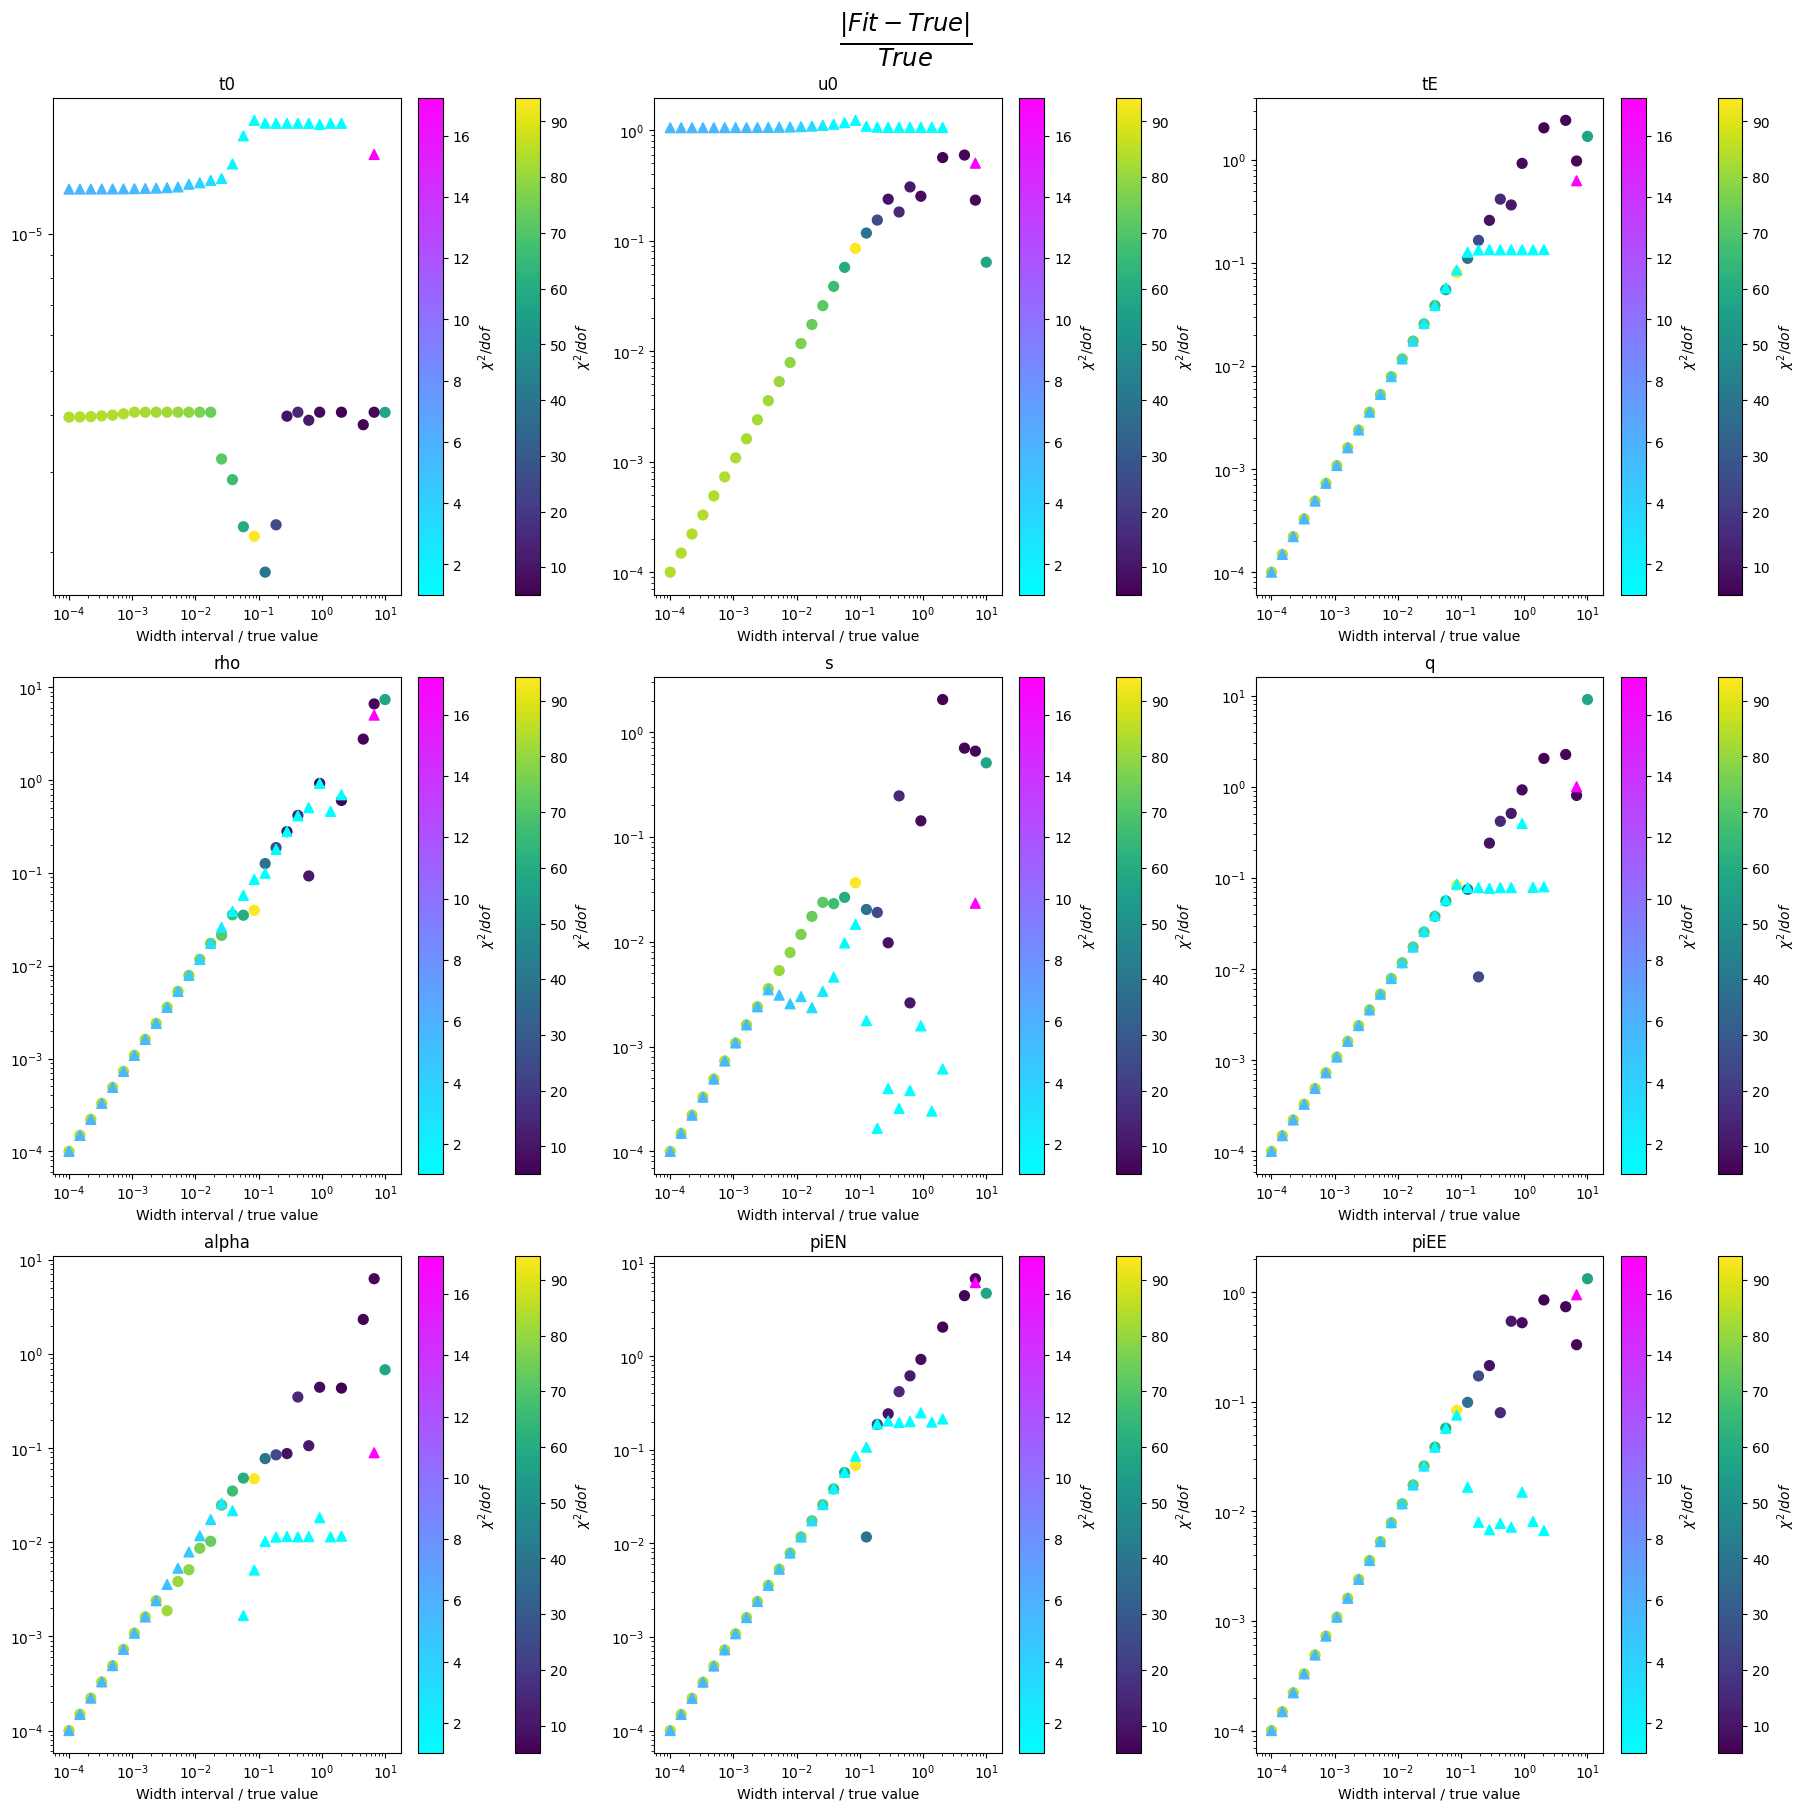

In [45]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot each key in the grid
for idx, key in enumerate(key_params):
    ax = axes[idx]
    scatter1 = ax.scatter(width, met_1[key], c=chi2_results, cmap='viridis', s=50)
    scatter = ax.scatter(R, met_1_dict[key],c= chi2,cmap='cool',marker='^', s=50)
    # ax.plot(width, met_1[key], ls='', lw=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # Add labels, title, and colorbar
    ax.set_xlabel('Width interval / true value')
    # ax.set_ylabel(r'$\sigma/fit$')
    ax.set_title(key)
    cbar = plt.colorbar(scatter1, ax=ax)
    cbar.set_label(r'$\chi^2/dof$')
    cbar2 = plt.colorbar(scatter, ax=ax)
    cbar2.set_label(r'$\chi^2/dof$')

# Hide any unused subplots
for ax in axes[len(key_params):]:
    ax.set_visible(False)

# fig.text(0.5, 0.01, "Width of interval", ha='center', fontsize=25)
plt.suptitle(r"$\frac{|Fit-True|}{True}$", fontsize=25)
# plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) 
plt.show()
